In [74]:
# Load dependencies
%matplotlib inline
import matplotlib
import json
import requests
import pickle
import os.path
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import decomposition
from scipy.stats import zscore, ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn3, venn3_circles
from IPython.display import display, HTML, Image

from copy import deepcopy
from clustergrammer_widget import *

net = Network(clustergrammer_widget)
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

def exp_f(x): 
    return 1.0/(10*x)

In [76]:
## Set up directory
SIGDIR = 'Signatures/'
if SIGDIR[:-1] not in os.listdir('.'): os.mkdir(SIGDIR)

## Load the data
data = pd.read_table('SampleGeneProfile.txt',index_col=0,low_memory=False)

patients = ['MF1','MF3','MF6']
trt_names = ['MF1','MF1-2','MF3','MF3-2','MF6','MF6-2']
ctr_names = ['A1','B1','C1','D1','E1']

expr = data[[x+'.AVG_Signal' for x in trt_names + ctr_names]]
pval = data[[x+'.Detection Pval' for x in trt_names + ctr_names]]

expr[expr < 0.0] = 0.0 # Map negative values to zero
expr.to_csv('MF_HumanBM_expr.txt',sep='\t')

expr.columns = [ x.replace('.AVG_Signal','') for x in expr.columns.values ]
pval.columns = [ x.replace('.Detection Pval','.pval') for x in pval.columns.values ]

## I. Quality Control

(34694, 11) before filtering...
(14697, 11) ... after filtering


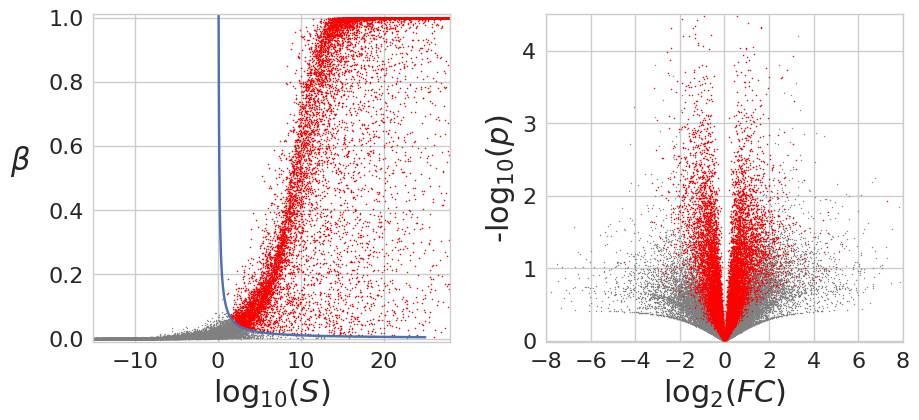

In [22]:
print expr.shape, "before filtering..."

# Multiple hypothesis correction
multi_p = 1.0 - pval.apply( lambda p: np.prod(1.0-p), axis=1)

trt = expr[trt_names]
ctr = expr[ctr_names]
fc = np.mean(trt, axis=1)/np.mean(ctr, axis=1)
tstat, t_pvals = ttest_ind(ctr, trt, axis=1, equal_var=False)
t_pvals = pd.Series(t_pvals, index=fc.index)

x1 = np.sum(np.log10(0.01 + expr),axis=1)
y1 = 1.0 - multi_p

x2 = np.log2(fc)
y2 = -np.log10(t_pvals)

keep = (y1 > exp_f(x1)) & (x1 > 0.0)

sns.set_style('whitegrid',rc={'font.sans-serif': ['Helvetica']})
fig = plt.figure(figsize=(10, 5), dpi=100)

## Left Plot
fig.add_subplot(1,2,1)
x = np.linspace(0, 25, 10000)
y = exp_f(x)
plt.plot(x, y)
plt.scatter(x1, y1, s=2, c='gray', marker='.')
plt.scatter(x1[keep], y1[keep], s=2, c='red', marker='.')
plt.xlabel(r'$\log_{10}(S)$',fontsize=22)
plt.ylabel(r'$\beta$',fontsize=22,rotation=0,labelpad=20)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
# plt.title(tissue.upper(),fontsize=24)
plt.axis([-15, 28, -0.01, 1.01])

## Right plot
fig.add_subplot(1,2,2)
plt.scatter(x2, y2, s=2, c='gray', marker='.')
plt.scatter(x2[keep], y2[keep],s=2,c='red',marker='.')
plt.xlabel(r'$\log_2(FC)$', fontsize=22)
plt.ylabel(r'-$\log_{10}(p)$', fontsize=22)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.axis([-8, 8, -0.01, 4.5])

fig.tight_layout( pad=3.0, w_pad=2, h_pad=2)

expr = expr[keep]
print expr.shape,'... after filtering'

#### Figure 1.  Filtering signatures by signal-to-noise ratio
Gene expression less than zero is mapped to zero. The following cutoff is used to select the genes with a reasonable signal-to-noise ratio:
##### $$\begin{align} \beta\cdot\log_{10}(S) > 0.1 \end{align}$$
where _S_ is the sum of log gene expresion across samples (signal), and $\beta$ is the power of the gene measurement (lack of noise). That is, we require that product of the detection power and the log sum gene expression be greater than 0.1. Thus when $\beta = 1.0$, we include a gene with $S\geq0.1$, and for $\beta = 0.1$, we require that $S\geq10$. Using this criteria, roughly half of the genes profiled were deemed to be below the detection threshold. 

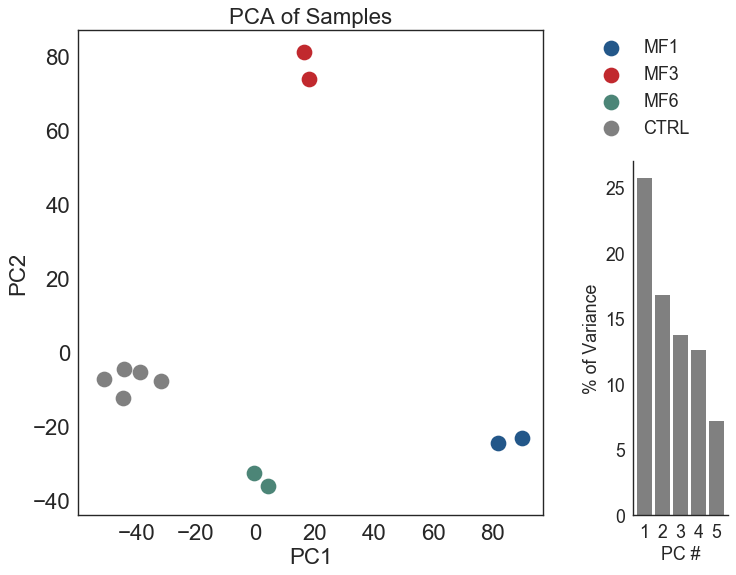

In [23]:
df = expr
mat = np.log2(df.transpose().as_matrix() + 1.0)

# Blue, Red, Green, Gray
colormap = { 'MF1':'#235789','MF3':'#C1292E','MF6':'#4C8577','CTRL':'gray' }

samples = df.columns.values
colors = np.array([ colormap[x.replace('-2','')] if 'MF' in x else 'gray' for x in samples])
labels = np.array(samples)

# Perform PCA
pca = decomposition.PCA(n_components=None)
pca.fit(mat)
variance_explained = pca.explained_variance_ratio_ * 100

pca_coords = pca.transform(mat)[:, 0:2]
pca1, pca2 = zip(*pca_coords)

# Plot Results
fig = plt.figure(figsize=(10, 8), dpi=80)

gs = gridspec.GridSpec(4, 4)
sns.set_style('white', rc={'font.sans-serif': ['Arial']})

ax1 = plt.subplot(gs[:,:-1]) # PCA

legs = []
# for color in colormap.values():
for patient in patients + ['CTRL']:
    color = colormap[patient]
    ix = [ i for i in range(len(colors)) if colors[i] == color]
    _x, _y = np.array(pca1)[ix], np.array(pca2)[ix]
    _ax = plt.scatter(_x, _y, s=200, c=color, lw = 0)
    legs.append(_ax)

plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("PCA of Samples",fontsize=20)
plt.legend(legs,('MF1','MF3','MF6','CTRL'), bbox_to_anchor=(1.35, 1.015), frameon=False, prop={'size':16})

ax2 = plt.subplot(gs[1:, -1]) # Percent of variance

plt.bar(range(1,6), variance_explained[:5], color='gray')

plt.xlabel('PC #',fontsize=16)
plt.ylabel('% of Variance',fontsize=16)
plt.xticks(range(1,6),range(1,6),fontsize=16)
plt.yticks(fontsize=16)

sns.despine(ax=ax2)
fig.tight_layout( pad=3.0, w_pad=3, h_pad=3)
plt.show()

#### Figure 2.  Principal Component Analysis
To assess the relationship between samples, we performed PCA on the log-transformed data. The strong separation and clustering of samples demostrates the quality of the data. The first principal component contains the difference between controls and patients with MF, about 25% of the variance in the data. 

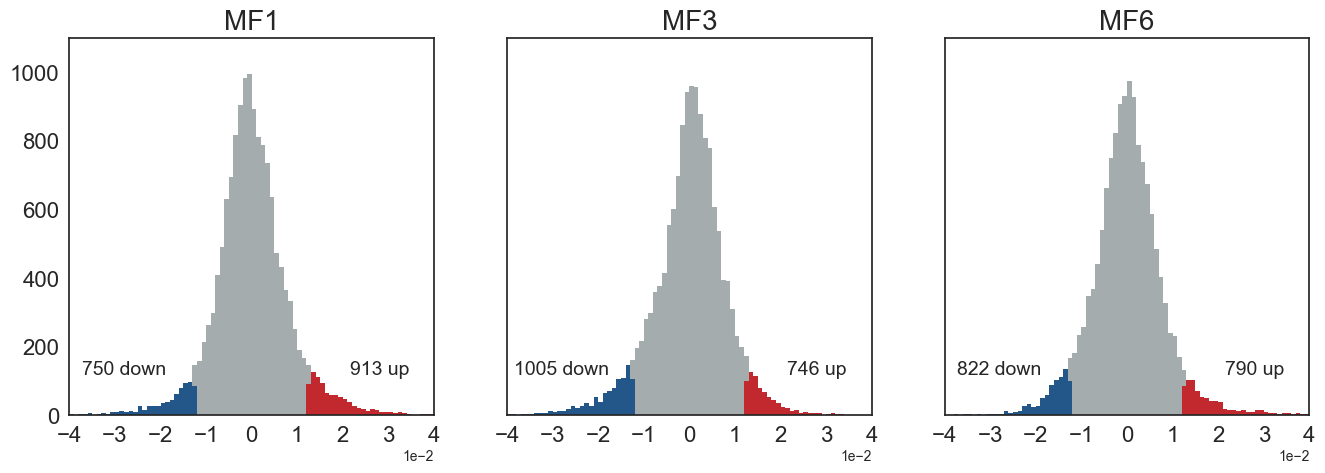

In [24]:
from chdir import chdir

df = np.log2(expr + 1.0) # Log-transform the data

cdsigs = {}; degs = {}

sns.set_style('white')
fig, ax = plt.subplots(1, 3, figsize=(16, 5), dpi=100, sharey=True)

ctrData = df[ctr_names]
genelist = df.index.values

for i in range(len(patients)):
    patient = patients[i]
    expData = df[[x for x in trt_names if patient in x]].values
    
     # do characteristic direction
    [cdGenes, cdVector] = chdir(ctrData,expData,genelist)
    s = pd.Series(cdVector, index=cdGenes, name=patient).sort_index().dropna()
    s = s[[ gene for gene in genelist if '$' not in gene ]]
    cdsigs[patient] = s
    
    # Identify DEGs
    dg = s[np.abs(s) > 1.5*np.std(s)].sort_values(ascending=False)
    degs[patient] = {'up': dg[dg<0.0], 'dn': dg[dg>0.0]}

    # Write to file
    with open(SIGDIR+patient+'_up.txt','w') as f: f.write('\n'.join(degs[patient]['up'].index))
    with open(SIGDIR+patient+'_dn.txt','w') as f: f.write('\n'.join(degs[patient]['dn'].index))       

    # Plot the distribution
    ax[i].hist(s,np.arange(-0.06,0.06,0.001),facecolor='#A5ACAE')
    ax[i].hist(dg[dg>0.0],np.arange(-0.06,0.06,0.001),facecolor='#C1292E')
    ax[i].hist(dg[dg<0.0],np.arange(-0.06,0.06,0.001),facecolor='#235789')
    ax[i].set_title(patient,fontsize=20)
    ax[i].annotate(str(len(dg[dg<0.0]))+' down',xy=(-3.4*np.std(s),120),fontsize=14,ha='center')
    ax[i].annotate(str(len(dg[dg>0.0]))+' up',xy=(3.4*np.std(s),120),fontsize=14,ha='center')
    ax[i].axis([-0.04,0.04,0,1100])
    ax[i].xaxis.get_major_formatter().set_powerlimits((0, 1))
    for tick in ax[i].xaxis.get_major_ticks() + ax[i].yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

#### Figure 3.  Selecting Differentially Expressed Genes
The characteristic direction was used to identify differentially expressed genes for each of the three patients. After computing the change in expression, the DEGs were selected by intentifying the genes with $| S_{CD} | > 1.5\cdot\sigma_{CD}$.

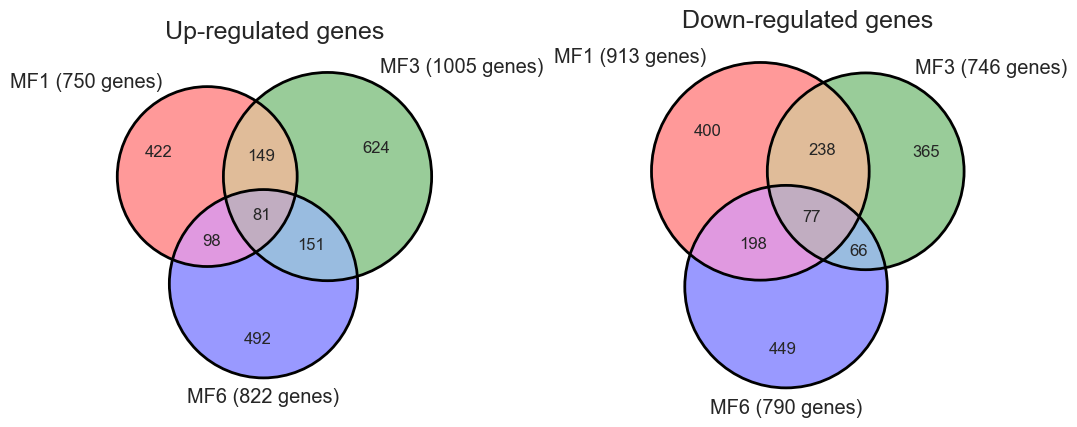

Intersecting Up-regulated genes:
ERAP2, TRIM38, SNTB2, VCAN, HS.548415, SDCCAG1, LOC643332, HIPK2, POLR1B, CD302, NLRP12, ZNF813, SNORA59A, MS4A3, TRIM52, SORL1, LOC642333, LOC100132910, FCER1A, LOC100128485, ASXL2, BASP1, CDC42SE1, ZNF264, FOXRED2, OLIG1, LOC653316, EPCAM, CEACAM4, CRISP2, HS.371060, TACSTD1, SLC46A2, PRTN3, ZNF281, LOC100131967, TCF4, RNASE3, RNASE2, LOC727900, HEATR3, RAB27A, SERPINB10, VNN1, LOC100170939, CLC, C19ORF39, RHOBTB3, AGMAT, KCNE1L, DLEU7, SNORD4A, MEGF9, CEP350, BRD3, C4ORF29, KCTD12, MGC42367, NMU, IL17RA, VHL, MTF1, SPIN1, LOC728519, HS.352549, CHURC1, FAM55C, MOSPD2, HS.354359, FAM164A, C20ORF177, LOC153561, GLB1L, PID1, LOC652775, FOLR3, NECAB1, FAM101B, ZNF562, AGPAT9, DUSP18

Intersecting Down-regulated genes:
STARD10, PDGFRB, FLVCR1, IL21R, RNU4ATAC, CCL3, NUAK1, CCL8, PROS1, SPHK1, FAM188B, NFKBIE, HES6, WDR86, TPM1, LOC100129445, KIAA0664, LOC388588, TMEM158, CTXN1, RSAD2, HS.545648, RNY5, A4GALT, JMJD6, FZD5, HS.541100, SMOX, CKB, JUN, ADRA2B,

In [25]:
fig = plt.figure(figsize=(10, 5), dpi=100)

consensus = {}; intersection = {}
rename = {'up':'Up-regulated','dn':'Down-regulated'}

for i, dirn in enumerate(['up','dn'],start=1):
    sets = []; labels = []
    for patient in patients:
        genelist = degs[patient][dirn].index.values
        sets.append( set(genelist) )
        labels.append( patient+' ('+str(len(genelist))+' genes)' )
    
    intersection[dirn] = list(sets[0] & sets[1] & sets[2])
    consensus[dirn] = list((sets[0] & sets[1]) | (sets[0] & sets[2]) | (sets[1] & sets[1]))
    with open(SIGDIR+'MFconsensus_'+dirn+'.txt','w') as f: f.write('\n'.join(consensus[dirn]))
    
    fig.add_subplot(1,2,i)
    venn3(sets, labels)
    venn3_circles(sets)
    plt.title(rename[dirn]+' genes',fontsize=18)
    
fig.tight_layout( pad=3.0, w_pad=10, h_pad=2)
plt.show()

for dirn in ['up','dn']:
    print "Intersecting",rename[dirn],"genes:"
    print ', '.join(intersection[dirn]) + '\n'

#### Figure 4. Overlap between samples of up- and down-regulated gene sets
The three signatures share about 77 up-regulated genes and 81 down-regulated genes.

## II. Enrichment Analysis

Enrichment analysis was accomplished via the Enrichr API. The most up- and down-regulated genes were submitted and enrichment results were retrieved for the following enrichment libraries:

In [28]:
# Libraries to use:
libraries = ['MGI_Mammalian_Phenotype_Level_4','WikiPathways_2016','GO_Biological_Process_2015',
             'ChEA_2016','PPI_Hub_Proteins','ENCODE_TF_ChIP-seq_2015','KEGG_2016']

# Use this function to call the Enrichr API:
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
def fetch_enrichr(genes, description=''):
    '''Returns a dict which maps Enrichr libraries to enrichment results.'''
    session = requests.session()
    payload = {'list': (None, genes), 'description': (None, description)}
    session.post(ENRICHR_URL, files=payload)
    results = {}
    for library in libraries:
        get_url = ENRICHR_URL + '?backgroundType=%s' % library
        response = session.get(get_url)
        if response.ok:
            results[library] = json.loads(response.text)[library]
        else: print "Error"
    return results

def enrichr2dataframe(results, name, score):
    '''Use this function to build a dataframe from enrichr results'''
    termsUp = {}; termsDn = {}
    value = {'cs':4, 'p-value':2, 'z-score':3}
    index = [ x[1] for x in results ]
    values = [ x[value[score]] for x in results ]
    return pd.Series(values, index=index, name=name)

def view_results(view_library, view_score, nrows=50):
    '''Use this function to build a clustergram visualization of enrichr results.
    Run net.widget() after.'''
    series = []
    for patient in patients:
        for dirn in ['up','dn']:
            name = patient+'_'+dirn
            s = enrichr2dataframe(enriched[patient][dirn][view_library], name, view_score)
            series.append(s)
    
    if view_score == 'z-score':
        df = -1.0*pd.concat(series,axis=1).fillna(0.0)
        keeprows = df.mean(axis=1).sort_values(ascending=False).iloc[range(nrows)].index.values    
        df = df.loc[keeprows]
    elif view_score == 'p-value':
        df = -np.log10(pd.concat(series,axis=1).fillna(0.0))

    df.columns = [ ('name: '+x, 'patient: '+x[:3], 'direction: '+x[-2:]) for x in df.columns]
    net.load_df(df)
    net.filter_N_top('row', nrows, 'sum')
    net.cluster(enrichrgram=False)

In [29]:
# Perform enrichment
enriched = {}
for patient in patients:
    enriched[patient] = {'up': fetch_enrichr('\n'.join(degs[patient]['up'].index),patient),
                         'dn': fetch_enrichr('\n'.join(degs[patient]['dn'].index),patient)}

### Enrichment Results
The heatmaps contains enrichment z-scores relative to the expected rank of the term in a random gene set.

1. **Reorder** the rows using "Rank by Sum" to identify the most consistantly significant enrichment terms across individuals.

2. **Double click** "direction" tab on the top right to separate up- and down-regulated signatures.

In [30]:
view_results('ENCODE_TF_ChIP-seq_2015','z-score',30)
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


#### Figure 5. Clustergram of Enrichment Terms from ENCODE Transcription Factors
Ranking by sum, STAT5A is the most significant transcription factor. STAT1, STAT2, and STAT3 also rank highly. JunD, which may protect cells from p53-dependent senescence/apoptosis is highly represented. Also significantly enriched is the Fos-gene family, particularly FOSL1 and FOSL2, which form leucine zipper proteins by dimerizing with JUN proteins. There are STAT1 and STAT5A binding sites at the promoter for FOSL1, FOSL2, and JUND. Ranked second is CEBPB, which also contains a leucine zipper domain. It regulates immune/inflammatory responses and is also involved in osteogenesis and macrophage activation.

In [31]:
view_results('ChEA_2016','z-score',nrows=30)
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


#### Figure 6. Clustergram of Enrichment Terms from ChEA Transcription Factors
Ranking by sum, SMAD is the most consistantly significant transcription factor across patients. Also ranking highly is NANOG, which is known to interact with SMAD, and blocks bone morphogenic mesoderm differentiation. Estrogen receptors ESR1 and ESR2 (which may dimerize) appear highly ranked; estrogen signaling has been shown to induce apoptosis of hematopoietic progenitors and myeloid neoplasms [[_Sachez-Aguilera et al._](http://www.sciencedirect.com/science/article/pii/S1934590914005141)].

In [32]:
view_results('KEGG_2016','z-score',nrows=15)
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


#### Figure 7. Clustergram of Enrichment Terms from KEGG Pathways
Ranking rows by sum, we see that "hematopoetic stem cell lineage" is the most highly-ranked term, which is highly consistent with myelofibrosis. Also very highly ranked are "Toll-like receptor signaling" and "NF-kappa B signaling pathway. Toll-like receptors are involved in regulation of the innate immune system, and are expressed on the surface of leukocytes. NF-kappa-B signaling plays a key roll in cytokine production, and is inhibited by TGF-beta in B lyphocytes and macrophages. Notably, "osteocast differentiation" and "cytokine-cytokine receptor iteraction" are highly ranked; these precesses are disregulated in myelofibrosis.

In [33]:
view_results('GO_Biological_Process_2015','z-score',15)
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


#### Figure 8. Clustergram of Enrichment Terms from GO Biological Process
Ranking rows by sum, the most significantly enriched biological processes involve (1) cytokine production and signaling, (2) inflammatory response, (3) wound healing, and (4) chemotaxis and leukocyte migration. Cell ular migration to the liver and spleen is a common characteristic of myelofibrosis.

## III. Drug Prediction Using L1000CDS2

In [69]:
L1000CDS2_URL = 'http://amp.pharm.mssm.edu/L1000CDS2/query'
def fetch_L1000CDS2_overlap(upGenes, dnGenes):
    '''Use this function to get L1000CDS2 results using the overlap search'''
    data = {'upGenes': upGenes, 'dnGenes':dnGenes}
    config = {"aggravate":False,"searchMethod":"geneSet","share":True,"combination":False,"db-version":"latest"}
    metadata = [{"key":"Tag","value":"myelofibrosis BM"},{"key":"Cell","value":"BM"}]
    payload = {"data":data,"config":config,"meta":metadata}
    headers = {'content-type':'application/json'}
    response = requests.post(L1000CDS2_URL,data=json.dumps(payload),headers=headers)
    if response.ok:
        output = response.json()
        ID = output['shareId']
        results = output['topMeta']
    return ID, results

def fetch_L1000CDS2_cosine(vector):
    '''Use this function to get L1000CDS2 results using the cosine search'''
    data = {'genes': list(vector.index.values), 'vals': list(vector.values)}
    config = {"aggravate":False,"searchMethod":"CD","share":True,"combination":False,"db-version":"latest"}
    metadata = [{"key":"Tag","value":"myelofibrosis BM"},{"key":"Cell","value":"BM"}]
    payload = {"data":data,"config":config,"meta":metadata}
    headers = {'content-type':'application/json'}
    response = requests.post(L1000CDS2_URL,data=json.dumps(payload),headers=headers)
    if response.ok:
        output = response.json()
        print output.keys()
        ID = output['shareId']
        results = output['topMeta']
    return ID, results

def L1000cds2dataframe(results,displayn=25):
    '''Use this function to build a dataframe from enrichr results'''
    frames = []
    for i, result in enumerate(results):
        if i == displayn: break
        drug = result['pert_desc'].title()
        if drug == '-666':
            drug = result['pert_id']
            
        dose = str(result['pert_dose']) + result['pert_dose_unit']
        time = str(result['pert_time']) + result['pert_time_unit']
        score = result['score']
        cell = result['cell_id']
        frames.append(pd.Series([score, drug, dose, time, cell],
                      index=['Score','Drug','Dose','Timepoint','Cell Type']))
        
    df = pd.concat(frames, axis=1).transpose()
    df.index = range(1,displayn+1)
        
    return df

In [72]:
# Get L1000CDS2 Results and make tables
upGenes = consensus['up']
dnGenes = consensus['dn']
ID, results = fetch_L1000CDS2_overlap(upGenes,dnGenes)
df = L1000cds2dataframe(results, 50)
df.to_csv('MF_Human_L1000CD2_reverse.txt',sep='\t')
print 'View full results here: http://amp.pharm.mssm.edu/L1000CDS2/#/result/'+ID
print display(df)

View full results here: http://amp.pharm.mssm.edu/L1000CDS2/#/result/58f14910e467bea600fc2b4e


,Score,Drug,Dose,Timepoint,Cell Type
1,0.0464,Narciclasine,10.0um,24.0h,A375
2,0.0385,BRD-K04853698,10.0um,6.0h,MCF7
3,0.0385,Phorbol-12-Myristate-13-Acetate (Pma),10.0um,6.0h,PL21
4,0.0385,BRD-A36630025,0.35um,6.0h,U937
5,0.0355,"Ingenol 3, 20-Dibenzoate",10.0um,6.0h,SKM1
6,0.0345,Narciclasine,10.0um,6.0h,A549
7,0.0345,BRD-K04853698,10.0um,24.0h,MCF7
8,0.0335,Cot-10B,44.4um,6.0h,VCAP
9,0.0325,Parthenolide,10.0um,24.0h,A375
10,0.0325,Narciclasine,10.0um,6.0h,HT29


None


#### Table 1. Drugs that may reverse the myelofibrosis gene signature
Using _[L1000CDS2](http://amp.pharm.mssm.edu/L1000CDS2/#/index)_, we can compare gene signatures from L1000 that to the consensus signature from the three myelofibrosis patients studied here. Using the 944 and 1103 genes that are up- and down-regulated (respectively) in at least two of the three patients, we can use vector operations to find signatures that may reverse the genetic changes characteristic of myelofibrosis. Notably, Narciclasine appears eleven times throughtout the list of the top 50. This drug is an alkaloid discovered in *Narcissus Amaryllidaceae*, which has recently been shown to have potential anti-tumor and anti-inflammatory effects [_[Furst](https://www.ncbi.nlm.nih.gov/pubmed/27542176)_].

### Enrichment of Consensus Signature
There is a strong signature for GATA1/2, SMAD4, STAT5A, and JAK-STAT signaling. View results on enrichr by accessing the links below.
- UP: http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1cxds
- DOWN: http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=1cxdr